In [1]:
from requests import get
from json import dumps
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import datetime
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
import scipy

In [2]:
def N_avg(a, N=7):
    # weekly avg into the past, shorten a
    b = np.zeros(len(a)-N)
    for i in range(N,len(a),1):
        b[i-N] = np.mean(a[i-N:i])
    return b

def N_avg_hard(a, N=3):
    # hard edged rolling avg, preserve len(a) by nan-ing
    b = np.zeros(len(a))
    b[:] = np.nan
    for i in range(N,len(a)-N,1):
        b[i] = np.mean(a[i-N:i+N])
    return b

def N_avg_soft(a, N=3):
    # soft edged rolling avg, preseve len a 
    b = np.zeros(len(a))
    for i in range(len(a)):
        l = max(0,i-N)
        r = min(i+N+1, len(a))
        b[i] = np.mean(a[l:r])
    return b

def diff_axis(scale, ax1, ax2):
    _,l1 = ax1.get_ylim()
    _,l2 = ax2.get_ylim()
    d1 = np.array(ax1.lines[0].get_ydata())
    d2 = np.array(ax2.lines[0].get_ydata())
    return np.mean(np.abs(d1/scale-d2))
    
def match_axis(ax1, ax2):
    scale = scipy.optimize.minimize(diff_axis, 1, args=(ax1,ax2))
    _,l2 = ax2.get_ylim()
    ax1.set_ylim(0,l2*scale.x)  
    return scale.x

In [3]:
# download api data for England
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=newAdmissions&metric=covidOccupiedMVBeds&format=json"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df_england = pd.DataFrame(response['body'])
df_england['dateTime'] = pd.to_datetime(df_england['date'])
df_england.sort_values(by=['dateTime'], inplace=True)
df_england.dropna(inplace=True)

top_date = sorted(list(set(df_england.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
print(top_date)

2021-12-27


In [4]:
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nhsRegion&metric=newAdmissions&metric=covidOccupiedMVBeds&format=json"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df_regions = pd.DataFrame(response['body'])
df_regions['dateTime'] = pd.to_datetime(df_regions['date'])
df_regions.sort_values(by=['dateTime'], inplace=True)
df_regions.dropna(inplace=True)

top_date = sorted(list(set(df_regions.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
print(top_date)

2021-12-27


In [5]:
# input defs
train_in_stream = []
train_out_stream = []
dates_train = []
test_in_stream = []
test_out_stream = []
dates_test = []

in_event = ""
out_event = ""
geographical_context = ""

train_start_date = "2020-10-01" 
train_end_date = "2021-04-01"
test_start_date = "2021-09-14"
test_end_date = top_date

#train_start_date = "2021-07-01" 
#train_end_date = "2021-12-01"
#test_start_date = "2021-10-01"
#test_end_date = top_date

In [6]:
# set data: England +ve tests -> hosp admissions
df = df_england
train_df = df[(df.dateTime >= train_start_date) & (df.dateTime <= train_end_date)]
test_df = df[(df.dateTime >= test_start_date) & (df.dateTime <= test_end_date)]

train_in_stream = np.array(train_df.newAdmissions.to_list(), dtype=float)
train_out_stream = np.array(train_df.covidOccupiedMVBeds.to_list(), dtype=float)
test_in_stream = np.array(test_df.newAdmissions.to_list(), dtype=float)
test_out_stream = np.array(test_df.covidOccupiedMVBeds.to_list(), dtype=float)
dates_train = sorted(list(set(train_df.dateTime.to_list())))
dates_test = sorted(list(set(test_df.dateTime.to_list())))

#train_in_stream = N_avg(train_in_stream)
#train_out_stream = N_avg(train_out_stream)
#test_in_stream = N_avg(test_in_stream)
#test_out_stream = N_avg(test_out_stream)

in_event = "admitted"
out_event = "mv bed occup"
geographical_context = "England"

In [7]:
# set data: Regional +ve tests -> hosp admissions
region = "London"
df = df_regions[df_regions.areaName==region]

train_df = df[(df.dateTime >= train_start_date) & (df.dateTime <= train_end_date)]
test_df = df[(df.dateTime >= test_start_date) & (df.dateTime <= test_end_date)]

train_in_stream = np.array(train_df.newAdmissions.to_list(), dtype=float)
train_out_stream = np.array(train_df.covidOccupiedMVBeds.to_list(), dtype=float)
test_in_stream = np.array(test_df.newAdmissions.to_list(), dtype=float)
test_out_stream = np.array(test_df.covidOccupiedMVBeds.to_list(), dtype=float)
dates_train = sorted(list(set(train_df.dateTime.to_list())))
dates_test = sorted(list(set(test_df.dateTime.to_list())))

#train_in_stream = N_avg(train_in_stream)
#train_out_stream = N_avg(train_out_stream)
#test_in_stream = N_avg(test_in_stream)
#test_out_stream = N_avg(test_out_stream)

in_event = "admitted"
out_event = "mv bed occup"
geographical_context = region

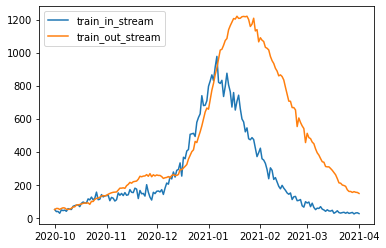

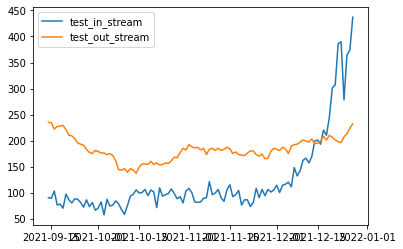

In [8]:
plt.clf()
plt.plot(dates_train, train_in_stream, label="train_in_stream")
plt.plot(dates_train, train_out_stream, label="train_out_stream")
plt.legend()
plt.show()
plt.clf()
plt.plot(dates_test, test_in_stream, label="test_in_stream")
plt.plot(dates_test, test_out_stream, label="test_out_stream")
plt.legend()
plt.show()

In [9]:
def _f(x, in_stream, out_stream):
    # model out_stream as a convolution of in_stream with x
    target_out_stream = out_stream[len(x)-1:]
    pred_out_stream = np.convolve(in_stream, x, mode="valid")
    return target_out_stream, pred_out_stream

def f(xs, in_stream=train_in_stream, out_stream=train_out_stream):
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _f(x, in_stream, out_stream)
        ret[i] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
    return ret        

In [10]:
n_dim = 60
n_particles = 1000

x_max = 0.1*np.ones(n_dim)
x_min = -0.005*np.ones(n_dim)
options = {'c1': 0.7, 'c2': 0.5, 'w': 0.5}
bounds = (x_min, x_max)
init_pos = np.array([np.zeros(n_dim) for i in range(n_particles)])

_minimizers = []

for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(f, 1000, verbose=True, n_processes=10)
    _minimizers.append(pos)
minimizers = np.array(_minimizers)

2021-12-30 16:37:54,088 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.7, 'c2': 0.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=22.2
2021-12-30 16:38:05,510 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 22.19682825147457, best pos: [ 0.03975518  0.0664261   0.05292612  0.0262172   0.05996303  0.02888282
  0.05615433  0.07831103  0.0658719   0.04587323  0.07119922  0.05700509
  0.06988427  0.05062804  0.03902244  0.08663603  0.03799477  0.03600482
  0.0251412   0.07144558  0.06370687  0.03269878  0.04718336  0.06571969
  0.04901209  0.0454466   0.02569744  0.01308551  0.05053848  0.01916521
  0.00461574  0.00452723 -0.00206554 -0.00426609  0.0339754   0.02581381
 -0.00182817 -0.00497909  0.02254436  0.04196343 -0.00231263  0.03729543
 -0.00491349 -0.00491308  0.0283387   0.02941482 -0.00453166  0.0296571
  0.03670746 -0.00458105  0.00107177 -0.00360243  0.00039836 -0.00489658
  0.01180895  0.00025

2021-12-30 16:39:30,458 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.7, 'c2': 0.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=20.6
2021-12-30 16:39:42,065 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 20.598382583193924, best pos: [ 0.06422334  0.07325751  0.07637708  0.0796068   0.02447064  0.08376951
  0.06470686  0.04380433  0.05628284  0.0364194   0.03419618  0.09992553
  0.03441057  0.04004283  0.02281636  0.05309388  0.08215159  0.07024203
  0.05409534  0.05617738  0.04437077  0.03977564  0.0505842   0.02421289
  0.03119002  0.03629599  0.05145907  0.03167466  0.01317783  0.02518897
  0.00054727  0.00829314  0.0011617   0.00390171  0.03023387 -0.00490247
  0.04505471  0.03490811 -0.00024097  0.0142193   0.0298937   0.01093056
  0.02016292 -0.00438935  0.01807608  0.01281475 -0.00272033 -0.0046914
  0.01689081  0.01636215  0.01543035 -0.00441552  0.00042108 -0.00101429
 -0.00104554  0.0100

2021-12-30 16:40:54,506 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.7, 'c2': 0.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=18.7
2021-12-30 16:41:00,687 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 18.733141894251148, best pos: [ 0.0561389   0.01360382  0.07097669  0.06418542  0.03505383  0.0997993
  0.04567029  0.05404554  0.02502837  0.04750386  0.09098312  0.09380397
  0.04062158  0.0662936   0.05295791  0.09995562  0.05687545  0.08261509
  0.04257219  0.02103825  0.07084553  0.01728268  0.01171     0.06961612
  0.00742494  0.01003874  0.00877057  0.04847657  0.01833512  0.01252251
  0.04412115  0.02683217 -0.00013869  0.01691174  0.00830577  0.0111886
  0.02257     0.0468338  -0.00461699  0.01682222  0.00517928 -0.00391015
 -0.00475715  0.01926486  0.01989398  0.04171057 -0.00487351  0.00734048
  0.05497486  0.00388006 -0.00409616 -0.00462008 -0.00466994 -0.00346655
 -0.00105583  0.02120

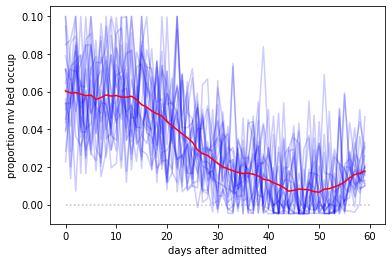

<Figure size 432x288 with 0 Axes>

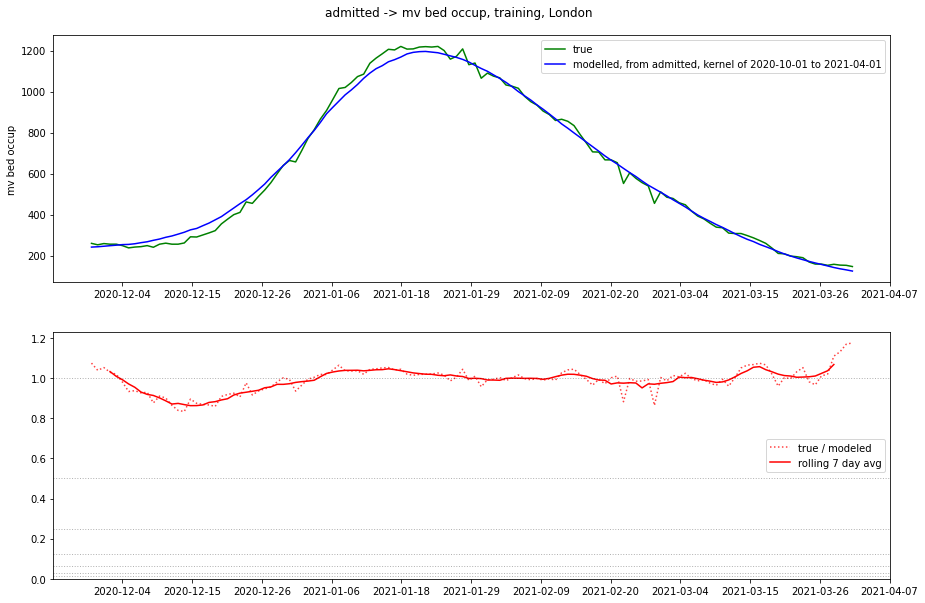

<Figure size 432x288 with 0 Axes>

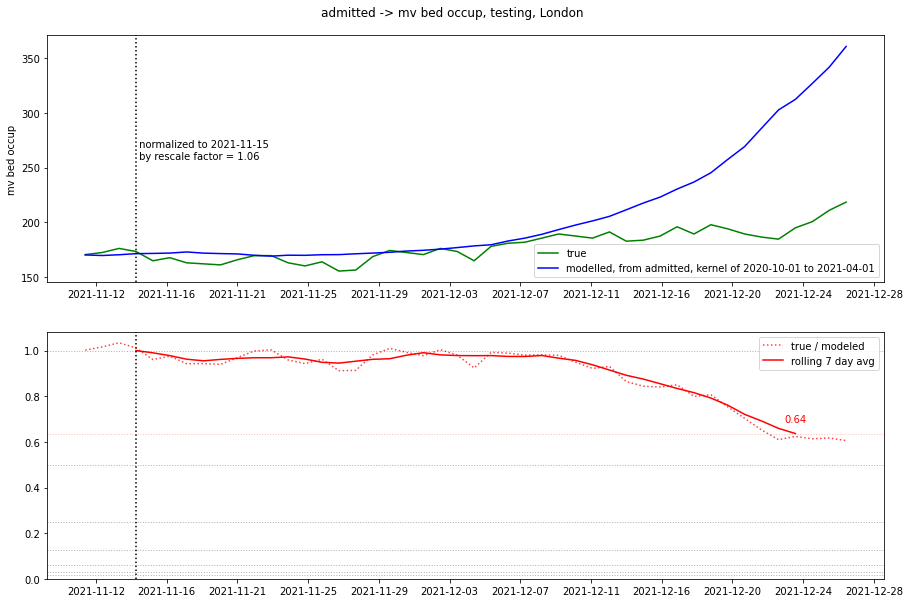

In [11]:
# show kernel
plt.clf()
z = list(range(len(pos)))
for y in minimizers:
    plt.plot(z, y, color="blue", alpha=0.2)
avg_minimizer = []
for i in range(len(minimizers[0])):
    avg_minimizer.append(np.mean(minimizers[:,i]))
avg_minimizer = np.array(avg_minimizer)
avg_minimizer = N_avg_soft(avg_minimizer, 3) 
plt.plot(z, avg_minimizer, color="red", alpha=1)
plt.xlabel("days after %s" % in_event)
plt.ylabel("proportion %s" % out_event)
plt.hlines(0, 0,len(z), ls="dotted", alpha=0.25, color="black")
plt.savefig("%s__%s__kernel__%s.png" % (in_event, out_event, geographical_context), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#print("mass: %.2f" % np.sum(avg_minimizer))

# show fit to training & testing
def make_graph(dates, kernel, in_stream, out_stream, test_train):
    plt.clf()
    assert(len(in_stream)==len(out_stream))
    assert(len(kernel)<=len(in_stream))
    fig, axes = plt.subplots(2,1, figsize=(15,10))
    ax1,ax2 = axes   
    
    true, pred = _f(avg_minimizer, in_stream, out_stream) 
    x = dates[-len(true):]
    diff = true/pred
    avg_diff = N_avg_hard(diff, 3)
    rescale_factor = 1
    if test_train=="test":
        rescale_factor = avg_diff[np.isfinite(avg_diff)][0]
    
    ax1.plot(x, true/rescale_factor, color="green", label="true")
    modeled_label = "modelled, from %s, kernel of %s to %s" % (in_event, train_start_date, train_end_date)
    ax1.plot(x, pred, color="blue", label=modeled_label)
    ax1.set_ylabel("%s" % out_event)
    ax1.legend()
    n_marks = 11
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(len(x)/n_marks))
    
    ax2.plot(x, diff/rescale_factor, color="red", alpha=0.75, ls="dotted", label="true / modeled")
    ax2.plot(x, avg_diff/rescale_factor, color="red", label="rolling 7 day avg")
    for i in range(7):
        ax2.axhline(y=2**(-i), ls="dotted", lw=1, alpha=0.3, color="black")        
    ax2.set_ylim(0,None)
    ax2.legend()
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(len(x)/n_marks))

    if test_train=="test":
        end_level = avg_diff[np.isfinite(avg_diff)][-1]
        ax2.axvline(x=x[3], color="black", ls="dotted")
        ax1.axvline(x=x[3], color="black", ls="dotted")
        y_min,y_max = ax1.get_ylim()
        y_mid = (y_min+y_max)/2 
        ax1.text(x[3], y_mid, " normalized to %s\n by rescale factor = %.2f" % (x[3].strftime("%Y-%m-%d"), rescale_factor), ha="left")
        ax2.axhline(y=end_level/rescale_factor, color="red", alpha=0.25, ls="dotted", lw=1)
        ax2.text(x[-4], end_level/rescale_factor+0.05, "%.2f" % (end_level/rescale_factor), ha="center", color="red")    
    
    fig.suptitle("%s -> %s, %sing, %s" % (in_event, out_event, test_train, geographical_context), y=0.92)
    plt.savefig("%s__%s__%s__%s.png" % (in_event, out_event, test_train, geographical_context), bbox_inches='tight', facecolor='white', transparent=False)
    plt.show()
    
make_graph(dates_train, avg_minimizer, train_in_stream, train_out_stream, "train") 
make_graph(dates_test, avg_minimizer, test_in_stream, test_out_stream, "test") 






In [12]:
print(avg_minimizer)

[0.06034584 0.05921452 0.05943051 0.05861846 0.05779245 0.05815035
 0.05584235 0.05682169 0.05816421 0.05760551 0.05786509 0.05709343
 0.0570113  0.05752897 0.05565883 0.05303291 0.05172147 0.04962034
 0.04826502 0.04696115 0.04408915 0.04188052 0.03967615 0.03750606
 0.0355038  0.03315182 0.02901485 0.02701774 0.02610293 0.02395645
 0.02185615 0.01997963 0.01892149 0.01790987 0.01704103 0.016462
 0.01660284 0.01610547 0.0151475  0.01342769 0.01289631 0.01158503
 0.01046977 0.00901605 0.00710629 0.00751399 0.00822912 0.00799596
 0.00782096 0.00684111 0.00652711 0.0081527  0.00843559 0.00938394
 0.01037853 0.01205116 0.01414261 0.01585615 0.01661618 0.01781221]
